## Importing libraries

In [1]:
#!pip install pyarrow
#!pip install scikit-spatial

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skspatial.objects import Plane

from sklearn.cluster import DBSCAN
from scipy.interpolate import UnivariateSpline

## Data visualization

In [3]:
def graph_3d(df, cluster):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if cluster == False:
        ax.scatter(df['x'], df['y'], df['z'], c='b', marker='o', s=8)
        
    else:  
        # Browse clusters and display points with different colours
        for cluster_id in df[cluster].unique():
            if cluster_id == -1:  # Points considered as noise
                continue
            cluster_data = df[df[cluster] == cluster_id]
            ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], label=f'Cluster {cluster_id}', s=8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.legend()

    plt.show()

In [4]:
def graph_2d(df, cluster, axis1, axis2):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    if cluster == False:
        ax.scatter(df[axis1], df[axis2], s=8)
        
    else:
        for cluster_id in df[cluster].unique():
            if cluster_id == -1:
                continue

            cluster_data = df[df[cluster] == cluster_id][[axis1, axis2]]

            ax.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster_id}', s=8)

    # Add axis labels
    ax.set_xlabel(axis1.upper())
    ax.set_ylabel(axis2.upper())
    
    ax.set_title('2D Scatter Plot')

    # Add a legend
    ax.legend()

    # Show the 2D visualization
    plt.show()

## Data Exploration

In [5]:
file_path = "files/lidar_cable_points_extrahard.parquet"

In [6]:
df_coordinates = pd.read_parquet(file_path)
df_coordinates.head()

,x,y,z
2211,6.037626,-13.231044,10.527397
2905,-10.721094,17.124476,10.943132
1411,2.893274,-3.527691,10.035204
251,5.870610,-10.909318,10.419144
794,-7.155748,12.846815,10.556583


In [7]:
print("DataFrame Length :", len(df_coordinates))

DataFrame Length : 1201


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


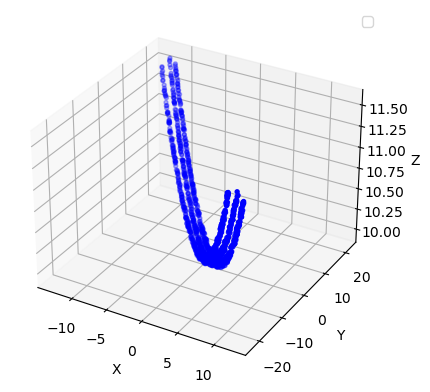

In [8]:
graph_3d(df_coordinates, False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


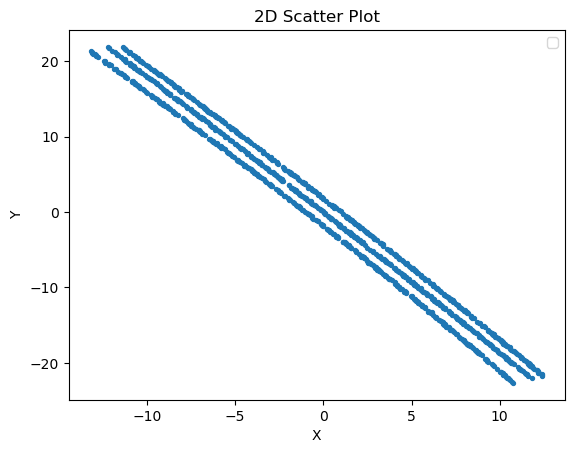

In [9]:
graph_2d(df_coordinates, False, 'x', 'y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


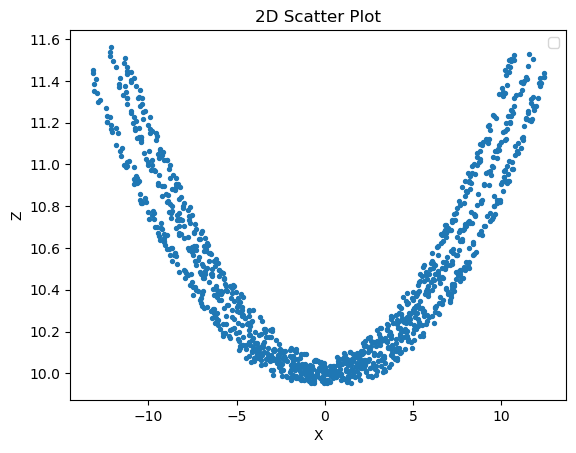

In [10]:
graph_2d(df_coordinates, False, 'x', 'z')

## Clustering large groups

In [11]:
dbscan = DBSCAN(eps=0.6, min_samples=5)

df_coordinates['cluster'] = dbscan.fit_predict(df_coordinates[['x', 'z']])

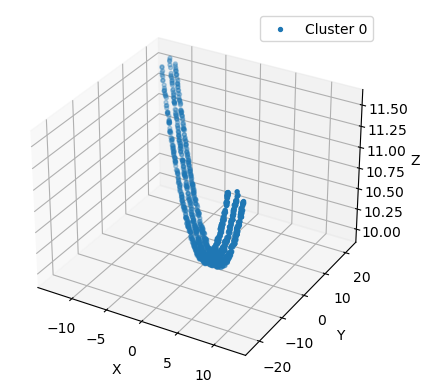

In [12]:
graph_3d(df_coordinates, 'cluster')

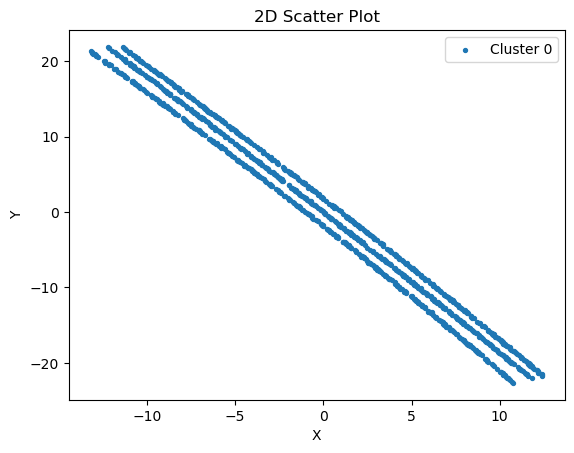

In [13]:
graph_2d(df_coordinates, 'cluster', 'x', 'y')

## Wire clustering

### Hough Transform

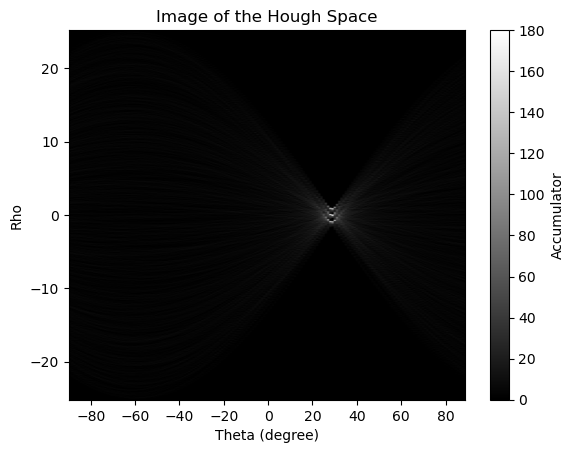

In [14]:
cluster_data = df_coordinates[df_coordinates['cluster'] == df_coordinates['cluster'].unique()[0]][['x', 'y']]

points = cluster_data[['x', 'y']].values

theta_values = np.deg2rad(np.arange(-90, 90))
rho_max = np.sqrt(np.sum(np.square(points.max(axis=0))))
rho_values = np.linspace(-rho_max, rho_max, num=500) 

accumulator = np.zeros((len(rho_values), len(theta_values)))

for point in points:
    x, y = point
    for theta_index, theta in enumerate(theta_values):
        rho = x * np.cos(theta) + y * np.sin(theta)
        rho_index = np.argmin(np.abs(rho_values - rho))
        accumulator[rho_index, theta_index] += 1

plt.imshow(accumulator, extent=[np.rad2deg(theta_values.min()), np.rad2deg(theta_values.max()),
                                rho_values.min(), rho_values.max()],
           cmap='gray', aspect='auto', origin='lower')

plt.colorbar(label='Accumulator')
plt.title('Image of the Hough Space')
plt.xlabel('Theta (degree)')
plt.ylabel('Rho')
plt.show()


In [15]:
def distance_to_line(point, theta, rho):
    x, y = point
    a = np.cos(theta)
    b = np.sin(theta)
    c = rho
    distance = abs(a * x + b * y + c) / np.sqrt(a**2 + b**2)
    return distance

def hough_transform_clustering(cluster_data):
    points = cluster_data[['x', 'y']].values

    theta_values = np.deg2rad(np.arange(-90, 90))
    rho_max = np.sqrt(np.sum(np.square(points.max(axis=0))))
    rho_values = np.linspace(-rho_max, rho_max, num=500)

    accumulator = np.zeros((len(rho_values), len(theta_values)))

    for point in points:
        x, y = point
        for theta_index, theta in enumerate(theta_values):
            rho = x * np.cos(theta) + y * np.sin(theta)
            rho_index = np.argmin(np.abs(rho_values - rho))
            accumulator[rho_index, theta_index] += 1

    threshold = 0.7 * np.max(accumulator)
    significant_rho_indices, significant_theta_indices = np.where(accumulator > threshold)

    #Merge close couples
    min_distance = 0.75
    best_couples = list(zip(theta_values[significant_theta_indices], rho_values[significant_rho_indices]))
    merged_couples = []

    for theta, rho in best_couples:
        if not any(abs(theta - t) < min_distance and abs(rho - r) < min_distance for t, r in merged_couples):
            merged_couples.append((theta, rho))

    # Assign each point to the closest cluster
    point_to_cluster = {idx: [] for idx in range(len(merged_couples))}
    for point_idx, point in enumerate(points):
        distances = [distance_to_line(point, theta, rho) for theta, rho in merged_couples]
        closest_line_idx = np.argmin(distances)
        point_to_cluster[closest_line_idx].append(cluster_data.index[point_idx])
        
    return point_to_cluster

# Used only for graphical representation with lines
def hough_transform_clustering_coordinates(cluster_data):
    points = cluster_data[['x', 'y']].values

    theta_values = np.deg2rad(np.arange(-90, 90))
    rho_max = np.sqrt(np.sum(np.square(points.max(axis=0))))
    rho_values = np.linspace(-rho_max, rho_max, num=500)

    accumulator = np.zeros((len(rho_values), len(theta_values)))

    for point in points:
        x, y = point
        for theta_index, theta in enumerate(theta_values):
            rho = x * np.cos(theta) + y * np.sin(theta)
            rho_index = np.argmin(np.abs(rho_values - rho))
            accumulator[rho_index, theta_index] += 1

    threshold = 0.7 * np.max(accumulator)
    significant_rho_indices, significant_theta_indices = np.where(accumulator > threshold)

    min_distance = 0.75
    best_couples = list(zip(theta_values[significant_theta_indices], rho_values[significant_rho_indices]))
    merged_couples = []

    for theta, rho in best_couples:
        if not any(abs(theta - t) < min_distance and abs(rho - r) < min_distance for t, r in merged_couples):
            merged_couples.append((theta, rho))

    # Create lines with the couple (theta, rho)
    lines = []
    for theta, rho in merged_couples:
        x_vals = np.linspace(points.min(axis=0)[0], points.max(axis=0)[0], num=100)
        y_vals = (rho - x_vals * np.cos(theta)) / np.sin(theta)
        lines.append((x_vals, y_vals))

    point_to_cluster = {idx: [] for idx in range(len(lines))}
    for point in points:
        distances = [distance_to_line(point, theta, rho) for theta, rho in merged_couples]
        closest_line_idx = np.argmin(distances)
        point_to_cluster[closest_line_idx].append(point)
        
    return point_to_cluster, lines

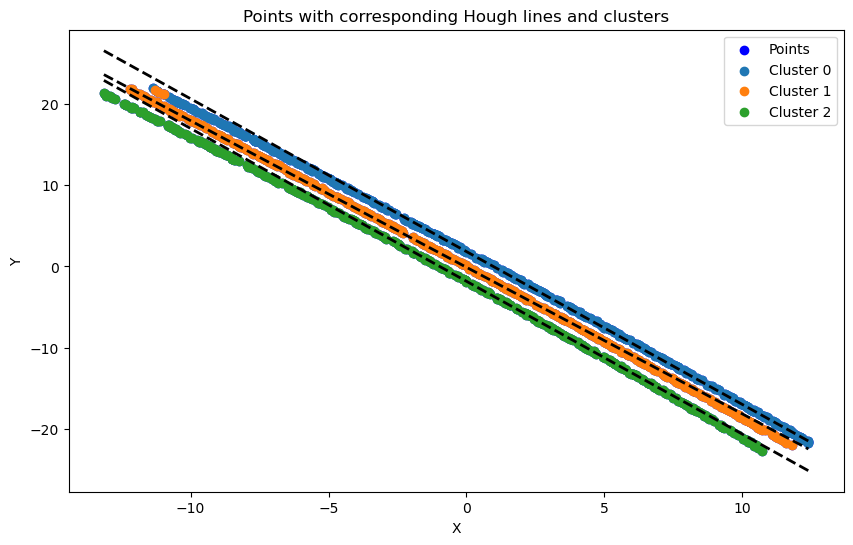

In [16]:
point_to_cluster, lines = hough_transform_clustering_coordinates(cluster_data)

plt.figure(figsize=(10, 6))
plt.scatter(points[:, 0], points[:, 1], c='blue', label='Points')
for idx, line in enumerate(lines):
    plt.plot(line[0], line[1], color='black', linestyle='--', linewidth=2)
    cluster_points = np.array(point_to_cluster[idx])
    if cluster_points.shape[0] > 0:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {idx}')

plt.title('Points with corresponding Hough lines and clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In the example above with the file extrahard, we can observe a slight curvature which leads to a cluster error for certain points, we could use a K means to divide the cloud of points into K large groups, and reuse the technique above to find clusters. However, we will instead draw the polynomial curve of degree 2 passing through these points and create the clusters by attaching the points to the closest curve.

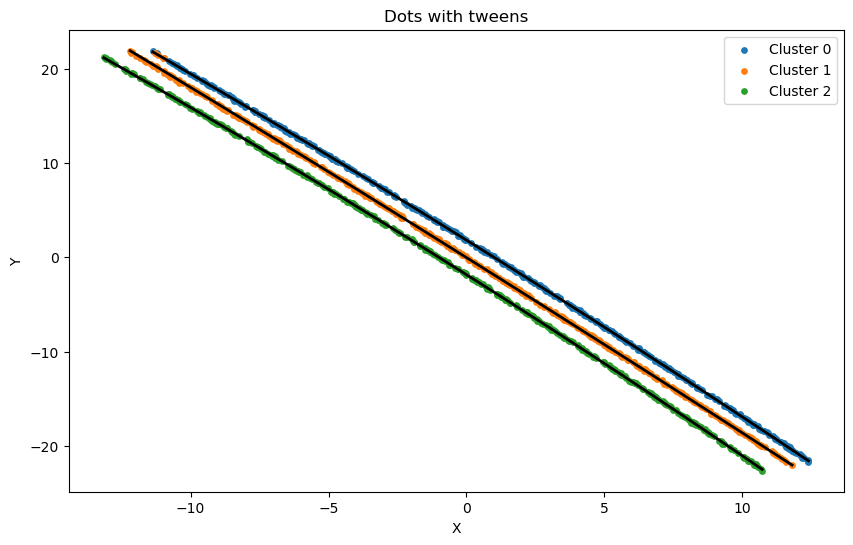

In [17]:
plt.figure(figsize=(10, 6))

for idx, line in enumerate(lines):
    cluster_points = np.array(point_to_cluster[idx])
    if cluster_points.shape[0] > 0:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {idx}', s=15)
        
        x_values, y_values = cluster_points[:, 0], cluster_points[:, 1]
        
        sorted_indices = np.argsort(x_values)
        x_values = x_values[sorted_indices]
        y_values = y_values[sorted_indices]
        
        spline = UnivariateSpline(x_values, y_values, k=2)
        
        x_interp = np.linspace(min(x_values), max(x_values), 100)
        y_interp = spline(x_interp)
        
        plt.plot(x_interp, y_interp, color='black', linewidth=2)

plt.title('Dots with tweens')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [18]:
df_coordinates['cluster_advanced'] = -1

for cluster_id in df_coordinates['cluster'].unique():
    if cluster_id == -1:
        continue
        
    cluster_data = df_coordinates[df_coordinates['cluster'] == cluster_id]
    point_to_cluster = hough_transform_clustering(cluster_data)
    
    for line_idx, cluster_indices in point_to_cluster.items():
        cluster_id = df_coordinates.loc[cluster_indices[0], 'cluster']
        advanced_cluster_id = f'Cluster_{cluster_id}_{line_idx}'
        df_coordinates.loc[cluster_indices, 'cluster_advanced'] = advanced_cluster_id
        
splines = []

for cluster_id in df_coordinates['cluster_advanced'].unique():
    if cluster_id == -1:
        continue
    
    cluster_data = df_coordinates[df_coordinates['cluster_advanced'] == cluster_id]
    x_values, y_values = cluster_data['x'], cluster_data['y']
        
    sorted_indices = np.argsort(x_values)
    x_values = x_values.iloc[sorted_indices]
    y_values = y_values.iloc[sorted_indices]
        
    spline = UnivariateSpline(x_values, y_values, k=2)
    splines.append(spline)

# We assign each point to the closest spline
point_to_spline = {}

for point_idx, row in df_coordinates.iterrows():
    point = np.array([row['x'], row['y']])
    min_distance = float('inf')
    closest_spline_idx = None
    
    for spline_idx, spline in enumerate(splines):
        y_interp = spline(point[0])
        distance = np.linalg.norm(point - np.array([point[0], y_interp]), ord=2)
        
        if distance < min_distance:
            min_distance = distance
            closest_spline_idx = spline_idx
    
    if closest_spline_idx is not None:
        if closest_spline_idx in point_to_spline:
            point_to_spline[closest_spline_idx].append(point_idx)
        else:
            point_to_spline[closest_spline_idx] = [point_idx]

for spline_idx, point_indices in point_to_spline.items():
    advanced_cluster_id = f'AdvancedCluster_{spline_idx}'
    df_coordinates.loc[point_indices, 'cluster_advanced'] = advanced_cluster_id

## Displaying the different clusters

<IPython.core.display.Javascript object>


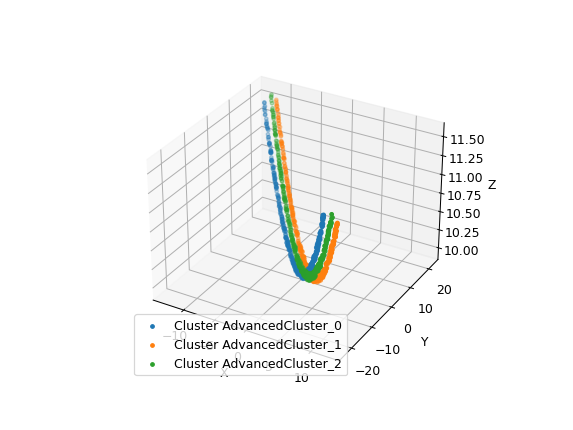

In [19]:
%matplotlib notebook
graph_3d(df_coordinates, 'cluster_advanced')

## Find the best plane

<IPython.core.display.Javascript object>


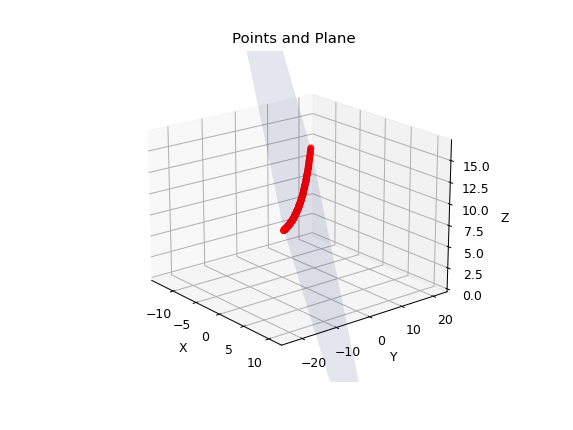

<IPython.core.display.Javascript object>


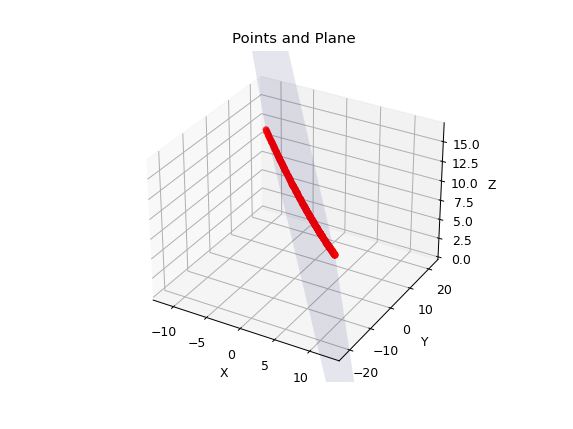

<IPython.core.display.Javascript object>


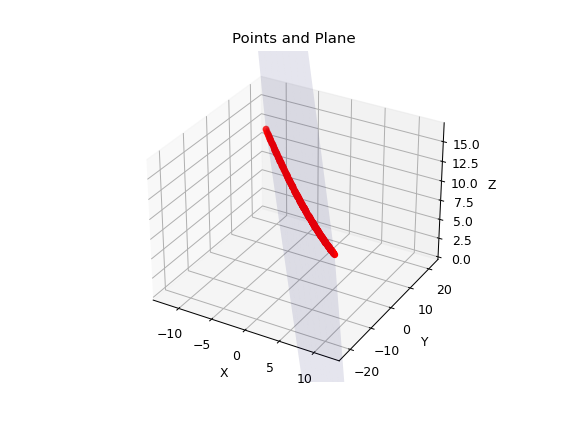

In [20]:
for cluster_id in df_coordinates['cluster_advanced'].unique():
    if cluster_id == -1:
        continue
        
    cluster_data = df_coordinates[df_coordinates['cluster_advanced'] == cluster_id][['x', 'y', 'z']]
    points = cluster_data.values

    # Calculate the best-fit plane
    plane = Plane.best_fit(points)
    plane_point = plane.point
    plane_normal = plane.normal
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='red', marker='o', label='Points')

    d = -plane_normal.dot(plane_point)
    xx, yy = np.meshgrid(np.linspace(min(points[:, 0]), max(points[:, 0]), 10),
                         np.linspace(min(points[:, 1]), max(points[:, 1]), 10))
    zz = (-plane_normal[0] * xx - plane_normal[1] * yy - d) / plane_normal[2]
    ax.plot_surface(xx, yy, zz, color='blue', alpha=0.1, linewidth=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Points and Plane')

    ax.set_zlim(0, 17)

    plt.show()
